### Описание/Пошаговая инструкция выполнения домашнего задания:

Набор данных представляет собой основные маршруты авиаперелетов в США за один месяц 2008-го года. В качестве модели распространения инфекции предлагается использовать SI (susceptible-infected) модель, в которой каждый аэропорт имеет два возможных состояния - “здоровый” или “зараженный”. Здоровый аэропорт может заразиться с некоторой вероятностью p (infection probability), если к нему прилетает самолет из зараженного города. Инфекция начинает распространение из некоторого стартового аэропорта и заканчивает распространение, когда все перелеты из датасета завершены.


### Часть 1. Пишем симуляцию.

- Напишите функцию для симуляции одного прохода по всему датасету и распространения инфекции. Функция должна принимать на вход стартовый город, в котором изначально началась инфекция и вероятность распространения инфекции p. На выходе функция должна возвращать словарь, в котором ключом будет время заражения аэропорта, значением - название аэропорта. В теле функции вам нужно написать проход по всему датасету (имеет смысл использовать itertuples), где вы будете проверять, является ли текущий рейс “заразным” и если да - с вероятностью p заражать новый аэропорт.
- В качестве стартовой ноды/аэропорта для симуляций можно использовать Allentown (node_id = 0).
    
### Часть 2. Как инфекционность (вероятность заражения) болезни влияет на скорость распространения?
- Давайте посмотрим, насколько заразной должна быть болезнь, чтобы заразить все аэропорты в сети. Для каждой из вероятностей p=[0.01, 0.05, 0.1, 0.5, 1.] прогоните по 10 симуляций распространения, каждый раз сохраняя результаты.
- Для каждых 12 часов симуляции посчитайте, какой средний процент аэропортов от общего их числа, был заражен к этому моменту времени. Постройте графики числа зараженных городов в зависимости от времени для каждой из вероятностей.

### Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?
- Настало время поработать с NetworkX. По имеющемуся датасету вам нужно построить ненаправленный граф всех аэропортов, используя относительное число перелетов между соседними аэропортами в качестве веса ребра. Например, если из аэропорта А в аэропорт Б суммарно есть 5 рейсов, из Б в А 10 рейсов, а всего в сети 150 перелетов, то вес ребра между А и Б должен быть равен (5+10)/150 = 0.1.
- Прогоните вашу симуляцию 50 раз, используя p=0.5 и стартовый аэропорт Allentown, каждый раз сохраняя результаты. Используя данные симуляций посчитайте медианное время до заражения каждого города.
- Теперь используя построенный вами граф, для каждого города посчитайте его коэффициент кластеризации (nx.clustering), степень (nx.degree) и центральность (nx.betweenness_centrality).
- Наконец, постройте scatter-plot-ы для медианного времени заражения и каждой из рассчитанных выше метрик. Также посчитайте коэффициент корреляции Спирмана между этими показателями и попробуйте проинтерпретировать полученные результаты. Какая из метрик графа сильнее всего скоррелирована со временем заражения? Почему?
- https://www.kaggle.com/datasets/vikalpdongre/us-flights-data-2008
- https://www.kaggle.com/datasets/flashgordon/usa-airport-dataset
- https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap

Useful links:

- https://augustinejoseph.medium.com/graph-data-structure-in-python-38dd58752836
- https://www.geeksforgeeks.org/graph-data-structure-and-algorithms/
- https://www.geeksforgeeks.org/python-timezone-conversion/


In [1]:
import random
from tqdm import tqdm

import dateutil
from datetime import datetime, timedelta
import pytz

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import networkx as nx

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('data/2008.csv')

In [3]:
df.shape

(7009728, 29)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7009728 entries, 0 to 7009727
Data columns (total 29 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Year               int64  
 1   Month              int64  
 2   DayofMonth         int64  
 3   DayOfWeek          int64  
 4   DepTime            float64
 5   CRSDepTime         int64  
 6   ArrTime            float64
 7   CRSArrTime         int64  
 8   UniqueCarrier      object 
 9   FlightNum          int64  
 10  TailNum            object 
 11  ActualElapsedTime  float64
 12  CRSElapsedTime     float64
 13  AirTime            float64
 14  ArrDelay           float64
 15  DepDelay           float64
 16  Origin             object 
 17  Dest               object 
 18  Distance           int64  
 19  TaxiIn             float64
 20  TaxiOut            float64
 21  Cancelled          int64  
 22  CancellationCode   object 
 23  Diverted           int64  
 24  CarrierDelay       float64
 25  WeatherDelay      

In [5]:
df.head()

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
0  2008      1           3          4   2003.0        1955   2211.0   
1  2008      1           3          4    754.0         735   1002.0   
2  2008      1           3          4    628.0         620    804.0   
3  2008      1           3          4    926.0         930   1054.0   
4  2008      1           3          4   1829.0        1755   1959.0   

   CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
0        2225            WN        335  ...    4.0      8.0          0   
1        1000            WN       3231  ...    5.0     10.0          0   
2         750            WN        448  ...    3.0     17.0          0   
3        1100            WN       1746  ...    3.0      7.0          0   
4        1925            WN       3920  ...    3.0     10.0          0   

   CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
0               NaN         0           NaN          NaN      NaN   
1               NaN         0           NaN          NaN      NaN   
2               NaN         0           NaN          NaN      NaN   
3               NaN         0           NaN          NaN      NaN   
4               NaN         0           2.0          0.0      0.0   

   SecurityDelay  LateAircraftDelay  
0            NaN                NaN  
1            NaN                NaN  
2            NaN                NaN  
3            NaN                NaN  
4            0.0               32.0  

[5 rows x 29 columns]

In [6]:
df['Origin'].nunique(), df['Dest'].nunique()

(303, 304)

## Подготовка данных

В наборе данных присутствуют записи о перелетах за весь 2008 год, объем данных очень большой - сократим его до 1 месяца, в соответствии с условиями задания

In [7]:
selected_month = 5  ## Выберем Май, прекрасный месяц... ))

In [8]:
df = df[df['Month'] == selected_month]

In [9]:
df.shape

(606293, 29)

In [10]:
df.isna().sum()

Year                      0
Month                     0
DayofMonth                0
DayOfWeek                 0
DepTime                6229
CRSDepTime                0
ArrTime                7083
CRSArrTime                0
UniqueCarrier             0
FlightNum                 0
TailNum                4613
ActualElapsedTime      7083
CRSElapsedTime           52
AirTime                7083
ArrDelay               7083
DepDelay               6229
Origin                    0
Dest                      0
Distance                  0
TaxiIn                 7083
TaxiOut                6229
Cancelled                 0
CancellationCode     600064
Diverted                  0
CarrierDelay         486167
WeatherDelay         486167
NASDelay             486167
SecurityDelay        486167
LateAircraftDelay    486167
dtype: int64

Атрибуты DepTime и ArrTime содержат большое количетсво null-значений, поэтому для дальнейшей работы будем использовать CRSDepTime и CRSArrTime

In [11]:
df

Year  Month  DayofMonth  DayOfWeek  DepTime  CRSDepTime  ArrTime  \
2389217  2008      5           3          6   1214.0        1210   1442.0   
2389218  2008      5           3          6    947.0         940   1104.0   
2389219  2008      5           3          6   1331.0        1335   1444.0   
2389220  2008      5           3          6   1615.0        1550   1723.0   
2389221  2008      5           3          6   1110.0        1100   1214.0   
...       ...    ...         ...        ...      ...         ...      ...   
2995505  2008      5          18          7   1621.0        1620   1750.0   
2995506  2008      5          18          7   1852.0        1855   2008.0   
2995507  2008      5          18          7   1734.0        1730   2000.0   
2995508  2008      5          18          7   1112.0        1115   1238.0   
2995509  2008      5          18          7   1841.0        1810   2004.0   

         CRSArrTime UniqueCarrier  FlightNum  ... TaxiIn  TaxiOut  Cancelled  \
2389217        1500            WN       2188  ...    3.0      5.0          0   
2389218        1055            WN        671  ...    3.0     11.0          0   
2389219        1450            WN        851  ...    4.0      8.0          0   
2389220        1705            WN       1039  ...    3.0      5.0          0   
2389221        1215            WN       1475  ...    3.0      3.0          0   
...             ...           ...        ...  ...    ...      ...        ...   
2995505        1754            DL       1401  ...   11.0     13.0          0   
2995506        2045            DL       1401  ...    3.0     15.0          0   
2995507        2002            DL       1402  ...   10.0     13.0          0   
2995508        1237            DL       1403  ...    9.0     25.0          0   
2995509        1931            DL       1404  ...    9.0     18.0          0   

         CancellationCode  Diverted  CarrierDelay WeatherDelay NASDelay  \
2389217               NaN         0           NaN          NaN      NaN   
2389218               NaN         0           NaN          NaN      NaN   
2389219               NaN         0           NaN          NaN      NaN   
2389220               NaN         0           0.0          0.0      0.0   
2389221               NaN         0           NaN          NaN      NaN   
...                   ...       ...           ...          ...      ...   
2995505               NaN         0           NaN          NaN      NaN   
2995506               NaN         0           NaN          NaN      NaN   
2995507               NaN         0           NaN          NaN      NaN   
2995508               NaN         0           NaN          NaN      NaN   
2995509               NaN         0          31.0          0.0      2.0   

         SecurityDelay  LateAircraftDelay  
2389217            NaN                NaN  
2389218            NaN                NaN  
2389219            NaN                NaN  
2389220            0.0               18.0  
2389221            NaN                NaN  
...                ...                ...  
2995505            NaN                NaN  
2995506            NaN                NaN  
2995507            NaN                NaN  
2995508            NaN                NaN  
2995509            0.0                0.0  

[606293 rows x 29 columns]

Поскольку в наборе данных указано локальное время, то для корректной оценки скорости распространения инфекции необходимо привести атрибуты времени к единому часовому поясу. Для этого загрузим временные зоны из [github](https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap) и используем их для перевода в формат UTC.

In [12]:
# Getting airports' timezone information
airport_tz = pd.read_fwf('https://raw.githubusercontent.com/hroptatyr/dateutils/tzmaps/iata.tzmap', \
                         names=['code', 'tz'], colspecs=[(0, 3), (3, None)])

In [13]:
airport_tz

code                  tz
0     AAA      Pacific/Tahiti
1     AAB  Australia/Brisbane
2     AAC        Africa/Cairo
3     AAD    Africa/Mogadishu
4     AAE      Africa/Algiers
...   ...                 ...
9049  ZYI       Asia/Shanghai
9050  ZYL          Asia/Dhaka
9051  ZZO       Asia/Sakhalin
9052  ZZU     Africa/Blantyre
9053  ZZV    America/New_York

[9054 rows x 2 columns]

Проверим, что у нас есть информация о тайм-зонах по всем аэропортам из набора данных

In [15]:
# make sure that all airports in our dataset are present
airports = pd.Series(df['Origin'].unique())
codes = airport_tz.code.unique()
bad = [ap not in codes for ap in airports]
for a in airports[bad]:
    print(a)

PFN


[PFN](https://en.wikipedia.org/wiki/Panama_City%E2%80%93Bay_County_International_Airport) это закрытый аэропот в Panama City, Florida. Его временная зона - America/Chicago. Добавим соответствующую запись в `airport_tz` dataset:

In [16]:
# Add time the airport timezone
airport_tz.loc[len(airport_tz.index)] = ['PFN', 'America/Chicago']
# Make code index
airport_tz = airport_tz.set_index('code')
# show tail
airport_tz.tail(2)

tz
code                  
ZZV   America/New_York
PFN    America/Chicago

In [17]:
df[['CRSDepTime', 'CRSArrTime']].describe()

CRSDepTime     CRSArrTime
count  606293.000000  606293.000000
mean     1326.192806    1492.467210
std       465.167425     484.255685
min        10.000000       1.000000
25%       925.000000    1111.000000
50%      1320.000000    1517.000000
75%      1715.000000    1906.000000
max      2359.000000    2400.000000

Данные о времени представлены в виде целочисленных значений, также мы видим, что CRSArrTime имеет максимальное значение 2400, что на самом деле является 00:00 следующего дня - для упрощения, заменим такие значения на 23:59 текущего дня.

Реализуем функцию для преобразования атрибутов Year, Month, DayOfMonth, CRSDepTime/CRSArrTime к типу pandas.datetime64

In [18]:
code = 'ABE'

In [19]:
dateutil.tz.gettz(airport_tz.loc[code, 'tz'])

tzfile('/usr/share/zoneinfo/America/New_York')

In [20]:
## Alternative approach to evaluate chances 
def plague_the_aeroport(p=0.5, iata_code=None):
    """
    Evaluates chances to plague to plage the aeroport with given probability p.
    Returns 1 if the aeroport was plagued, otherwise returns 0
    """
    probability_distribution = [0,1]
    weights = [1-p, p]
    random_value = random.choices(probability_distribution, weights=weights, k=1)
    return random_value[0]

In [21]:
def to_time(int_var):
    """
    Returns time recorded as integer and format it as time (24h) in string format.
    Examples:
    1 -> 00:01
    41 -> 00:41
    537 -> 05:37
    1714 -> 17:14
    """
    str_var = str(int_var).rjust(4, '0')
    return str_var[:2] + ':' + str_var[2:]

@np.vectorize
def get_tz(code):
    """
    Returns time zone as dateutil.tz.tz.tzfile from airport code
    """
    tz = dateutil.tz.gettz(airport_tz.loc[code, 'tz'])
    return tz

@np.vectorize
def to_datetime(year, month, day, time, tz):
    """
    Returns datatime in UTC
    """
    h, m = time.split(sep=':')
    result = datetime(year, month, day, int(h), int(m), tzinfo=tz).astimezone(pytz.utc)  #.replace(tzinfo=None)
    return result
    #return np.datetime64(result)

def preprocess(df):
    
    # replace 24:00 with 23:53
    df.loc[df['CRSArrTime'] >= 2400, 'CRSArrTime'] = 2359
    df.loc[df['CRSDepTime'] >= 2400, 'CRSArrTime'] = 2359
    
    # create column with departure and arrival time as string
    df['arr_time'] = df['CRSArrTime'].apply(to_time)
    df['dep_time'] = df['CRSDepTime'].apply(to_time)
    
    # create datetime columns
    df['arr_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['arr_time'], get_tz(df['Dest']))
    df['dep_datetime'] = to_datetime(df['Year'], df['Month'], df['DayofMonth'], df['dep_time'], get_tz(df['Origin']))
    
    # leave only relevant columns 
    result = df[['dep_datetime', 'Origin', 'arr_datetime', 'Dest']]

    # rename columns
    result.columns = ['departure', 'origin', 'arrival', 'dest']
    
    # control for night flights
    result.loc[result['departure'] > result['arrival'], 'arrival'] += timedelta(hours=24)

    # sort by departure time
    result.sort_values('departure', inplace=True)
    
    return result

и выполним преобразование

In [22]:
df = preprocess(df).reset_index(drop=True)

In [23]:
df.head()

departure origin                   arrival dest
0 2008-05-01 06:30:00+00:00    SLC 2008-05-01 11:10:00+00:00  JFK
1 2008-05-01 06:35:00+00:00    SLC 2008-05-01 09:59:00+00:00  ATL
2 2008-05-01 06:50:00+00:00    DEN 2008-05-01 09:31:00+00:00  ATL
3 2008-05-01 06:55:00+00:00    DEN 2008-05-01 10:34:00+00:00  JFK
4 2008-05-01 07:10:00+00:00    LAX 2008-05-01 10:00:00+00:00  DFW

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 606293 entries, 0 to 606292
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype              
---  ------     --------------   -----              
 0   departure  606293 non-null  datetime64[ns, UTC]
 1   origin     606293 non-null  object             
 2   arrival    606293 non-null  datetime64[ns, UTC]
 3   dest       606293 non-null  object             
dtypes: datetime64[ns, UTC](2), object(2)
memory usage: 18.5+ MB


Набор данных сокращен до 4-х минимально необходимых атрибутов. Атрибуты времени вылета и прилета, для корректности сравнения и оценки распространения инфекции, приведены к единому формату в UTC.

## Часть 1. Построение симуляции

In [25]:
initial_dt = to_datetime([2008], [5], [1], ['00:00'], [pytz.utc])[0]
def do_simulation(airport, p, debug=False):
    """
    Run infection spreading simulation
    :param airport: str
        airport code of initially infected airport
    :param p: float
        probability of a new airport being infected
    :param debug: bool, default False
        If True print debugging information
    :return: dict
        dictionary of infection spreading. datetime as a key and airport code as data.
    """
    infected = [airport]
    results = {airport: initial_dt}

    for row in df.itertuples():
        chance = np.random.uniform()
        # origin infected, dst is not infected yet and checking probability of infection
        if (row.origin in infected) and (row.dest not in infected) and (chance <= p):
            # control for flights which should not be infected yet 
            #(infection flight arrival is in future in comparison to departure flights to other airports)
            if results[row.origin] > row.departure:
                if debug:
                    print('too early!', row)
                continue
            if debug:
                print('Infected!!', row)
            infected.append(row.dest)
            results[row.dest] = row.arrival
        else:
            continue
    return results

Протестируем распространение инфекции: в качестве начальной точки распространения инфекции выберем аэропорт Allentown (IATA: 'ABE') с минимальной вероятностью заражения р = 0.01

In [26]:
airport = 'ABE'
p = 0.01

In [27]:
# number of airports
N = len(df['origin'].unique())
print('Starting airport:', airport)
np.random.seed(13)
res = do_simulation(airport, p)
print(f'Infected in a month: {len(res)}/{N} ~ {len(res)/N*100:.0f}% of airports')

Starting airport: ABE
Infected in a month: 233/287 ~ 81% of airports


## Часть 2. Оценка влияния заразности инфекции на скорость распространения

In [28]:
def run_simulations(airport, probs, n, debug=False):
    results = pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
    for p in probs:
        print('simulations for p =', p)
        for i in tqdm(range(n)):
            # run simulation
            sim_res = pd.DataFrame.from_dict(do_simulation(airport, p), orient='index').reset_index()
            sim_res.columns = ['airport', 'infected']
            sim_res['sim_id'] = i
            sim_res['p'] = p
            results = pd.concat([results, sim_res]) 
    return results

In [29]:
# List of probabilities
probs = [0.01, 0.05, 0.1, 0.5, 1]
# number of simulations
n_sim = 10
# fix seed
np.random.seed(13)
print('Starting airport:', airport)
# DataFrame for results
results_df = run_simulations(airport, probs, n_sim) #pd.DataFrame(columns=['p', 'sim_id', 'airport', 'infected'])
#results_df.to_pickle('results.pkl')

Starting airport: ABE
simulations for p = 0.01


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.72s/it]


simulations for p = 0.05


100%|███████████████████████████████████████████| 10/10 [00:37<00:00,  3.78s/it]


simulations for p = 0.1


100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.82s/it]


simulations for p = 0.5


100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.89s/it]


simulations for p = 1


100%|███████████████████████████████████████████| 10/10 [00:38<00:00,  3.85s/it]


In [30]:
# Dataset time boundaries
min_time = df['departure'].min()
max_time = df['arrival'].max()
print(f'From {min_time} to {max_time}')

# dictionary to record results
tsim_res = dict()

# time delta
dt = timedelta(hours=12)

# time point
tp = min_time
while tp < max_time:
    infected_pct = results_df[results_df.infected <= tp].groupby(['p', 'sim_id']).size()/N
    infected_pct = infected_pct.reset_index().groupby('p')[0].mean()
    tsim_res[tp] = infected_pct
    tp += dt

From 2008-05-01 06:30:00+00:00 to 2008-06-01 15:30:00+00:00


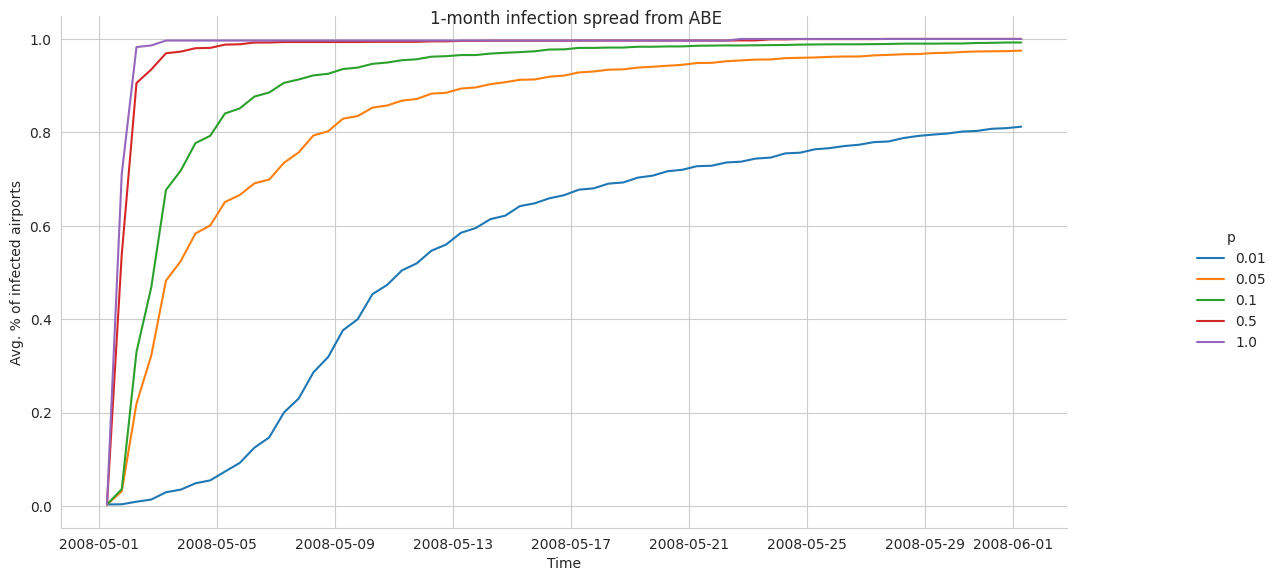

In [31]:
# Creating dataframe for visualisation
data_viz = pd.DataFrame.from_dict(tsim_res, orient='index')
data_viz = data_viz.reset_index().melt(id_vars='index', var_name='p')
data_viz['p'] = data_viz.p.astype('category')
# Visualising
sns.set_style('whitegrid')
lp = sns.relplot(data=data_viz, kind='line', x='index', y='value', hue='p')
lp.fig.set_figwidth(14)
lp.fig.set_figheight(6)
lp.fig.suptitle(f'1-month infection spread from {airport}')
lp.ax.set_xlabel('Time')
lp.ax.set_ylabel('Avg. % of infected airports')
plt.show()

## Часть 3. Может ли информация о сети помочь предсказать, кто будет заражен?

### Building graph

In [32]:
@np.vectorize
def combine_orig_dst(origin, dst):
    """
    Combine airport codes in aphabetical order
    """
    if origin < dst:
        result = f'{origin} {dst}'
    else:
        result = f'{dst} {origin}'
    return result

In [33]:
# Number of flights
NF = df.shape[0]

# Create edgelist from dataframe
df['edge'] = combine_orig_dst(df.origin, df.dest)
edgelist = df.groupby('edge').size()/NF
edgelist = edgelist.reset_index()
edgelist[['node1', 'node2']] = edgelist['edge'].str.split(pat=' ', n=1, expand=True)   ##str.split(' ', 1, expand=True)
edgelist = edgelist[['node1', 'node2', 0]]
edgelist.columns = ['node1', 'node2', 'weight']
edgelist.to_csv('edgelist.csv', header=False, index=False, sep=' ')
edgelist

node1 node2    weight
0      ABE   ATL  0.000205
1      ABE   CLE  0.000246
2      ABE   CLT  0.000102
3      ABE   CVG  0.000185
4      ABE   DTW  0.000257
...    ...   ...       ...
2290   SNA   STL  0.000101
2291   STL   TPA  0.000312
2292   STL   TUL  0.000252
2293   SWF   TPA  0.000102
2294   TLH   TPA  0.000068

[2295 rows x 3 columns]

In [34]:
# Create graph
graph = nx.read_weighted_edgelist('edgelist.csv', nodetype=str)
print(graph.number_of_nodes(), 'nodes and ', graph.number_of_edges(), 'edges in the graph')

287 nodes and  2295 edges in the graph


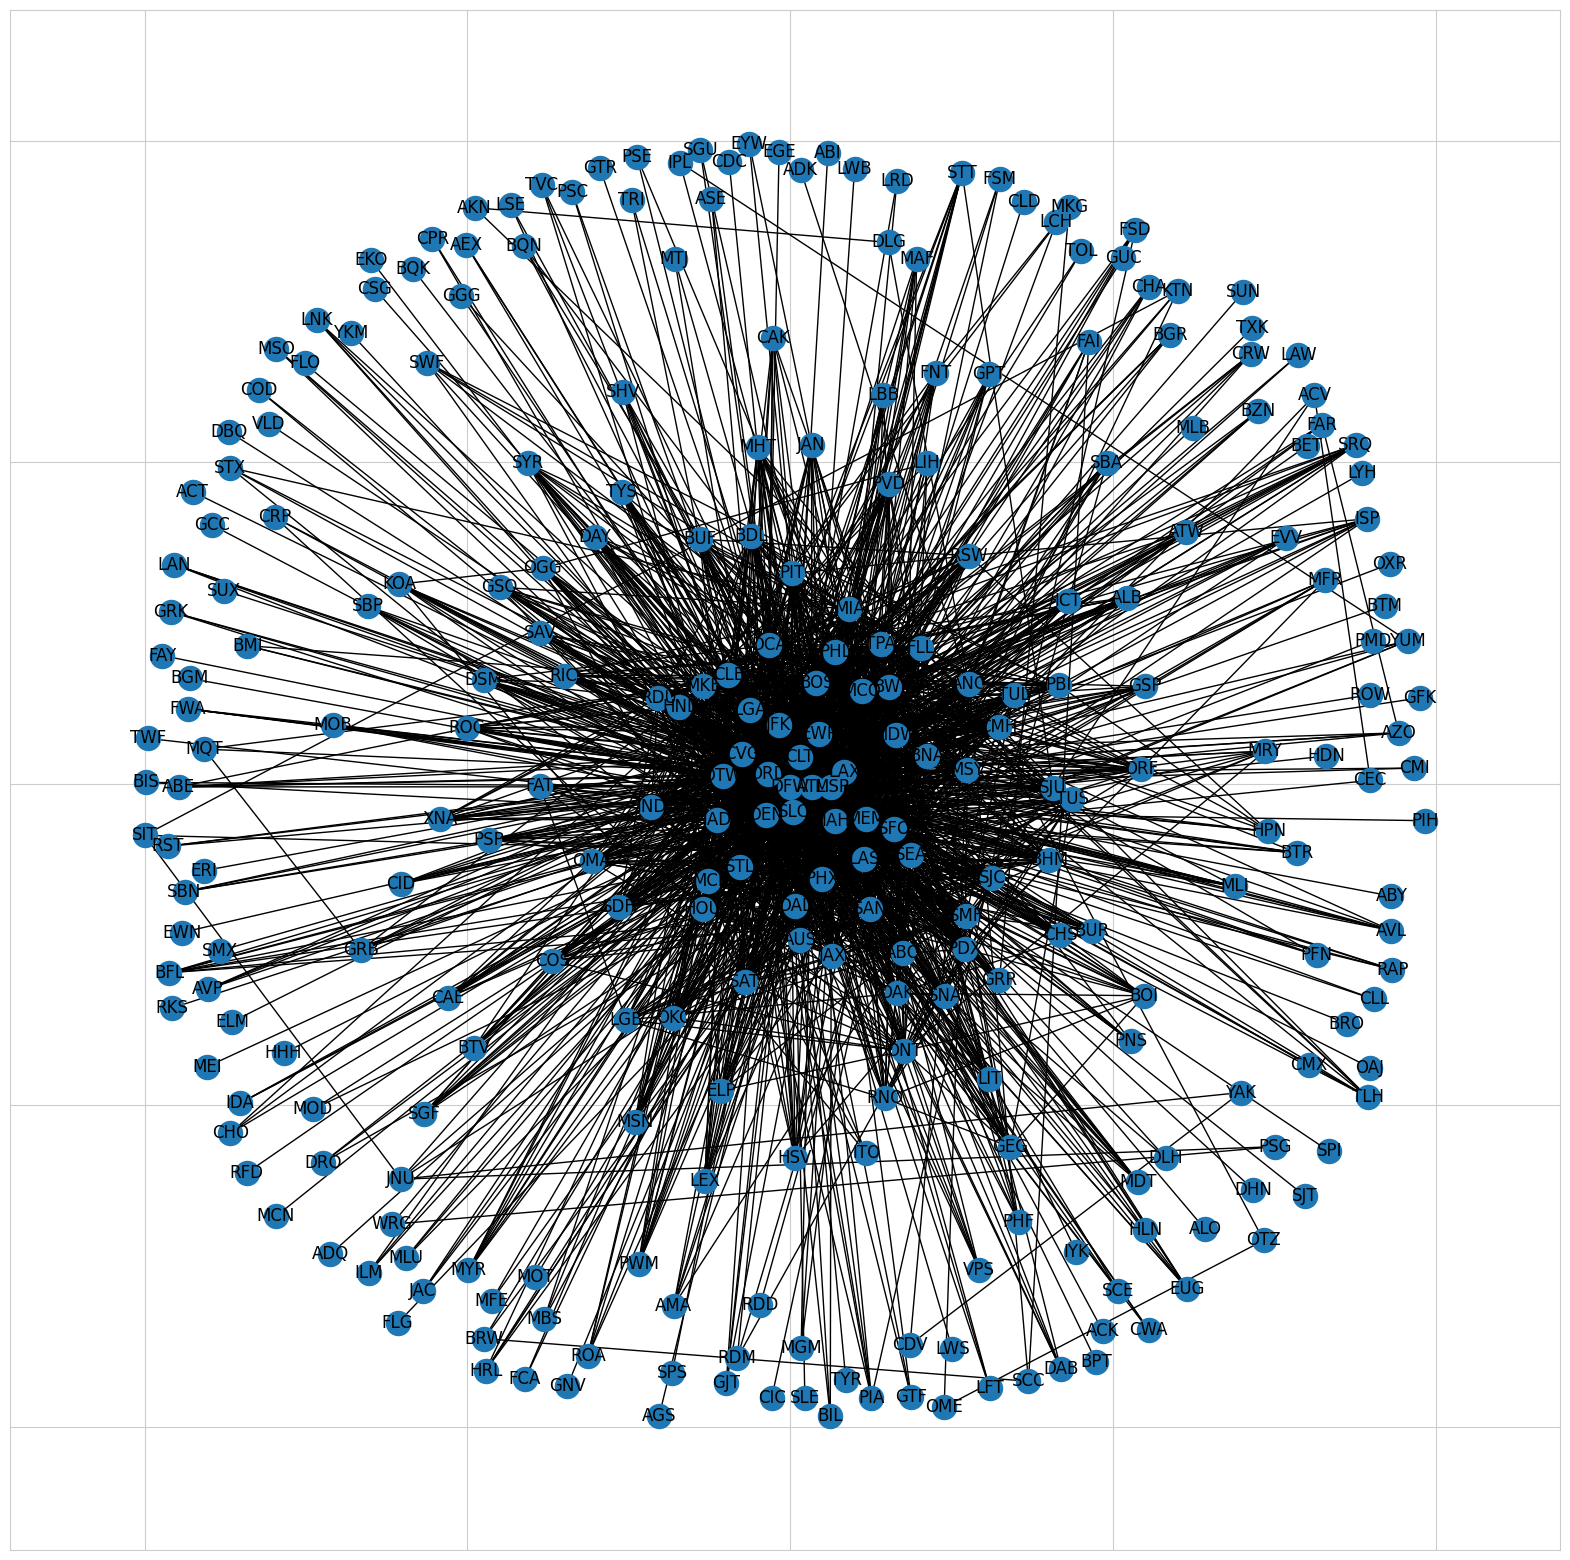

In [35]:
fig = plt.figure(1, figsize=(20, 20))
nx.draw_networkx(graph)

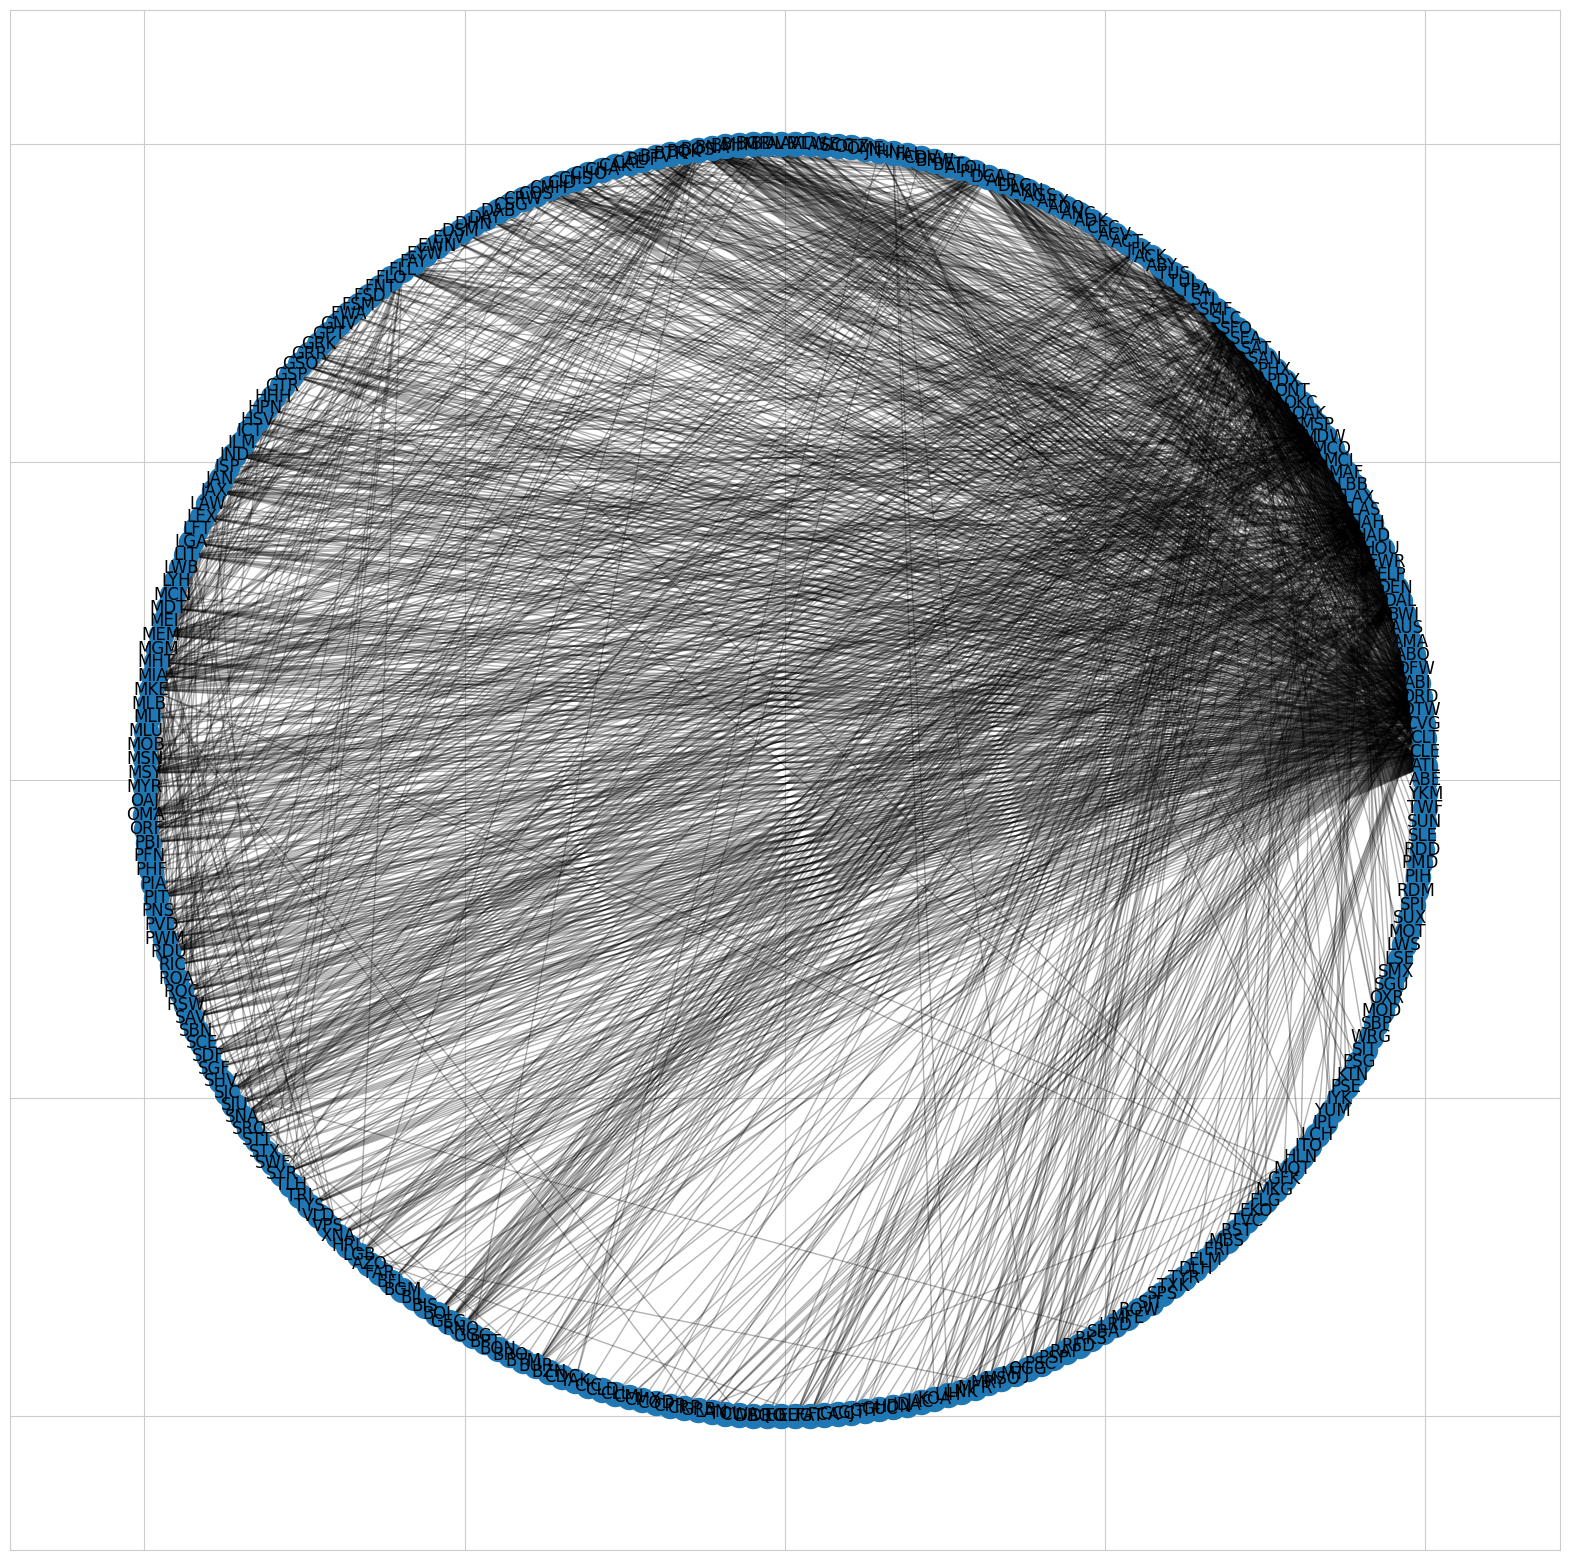

In [36]:
fig = plt.figure(1, figsize=(20, 20))
pos=nx.circular_layout(graph)
nx.draw_networkx_nodes(graph,pos=pos)
nx.draw_networkx_edges(graph,pos=pos,alpha=0.3)
nx.draw_networkx_labels(graph, pos=pos)
plt.show()

### Расчет метрик

In [37]:
clustering = nx.clustering(graph, weight='weight')
degree = dict(graph.degree(weight='weight'))
centrality = nx.betweenness_centrality(graph, weight='weight')

In [38]:
# Combine metrics to DataFrame
node_metrics = pd.DataFrame.from_dict(clustering ,orient='index', columns=['clustering']).join([
    pd.DataFrame.from_dict(degree ,orient='index', columns=['degree']),
    pd.DataFrame.from_dict(centrality ,orient='index', columns=['centrality'])
])
node_metrics.head()

clustering    degree  centrality
ABE    0.090509  0.001385    0.000000
ATL    0.025298  0.114050    0.167740
CLE    0.038383  0.019789    0.257576
CLT    0.059393  0.036273    0.044675
CVG    0.024199  0.026588    0.205157

### Запуск симуляции

In [39]:
np.random.seed(13)
results_50 = run_simulations('ABE', [0.5], 50)

simulations for p = 0.5


100%|███████████████████████████████████████████| 50/50 [03:25<00:00,  4.11s/it]


In [40]:
results_50 = results_50.reset_index(drop=True)
# Starting time
st = results_50.loc[0, 'infected']
st
# Calculate time before infection (dt)
results_50['dt'] = results_50['infected'] - st
# Calculate median time
median_time = results_50.groupby('airport')['dt'].median()
assert median_time.isna().sum() == 0

In [41]:
# Join median time with node metrics
ap_metrics = node_metrics.join(median_time)
# Convert timedelta to hours
ap_metrics['hours'] = ap_metrics['dt'].dt.seconds/60/60
ap_metrics.head()

clustering    degree  centrality              dt      hours
ABE    0.090509  0.001385    0.000000 0 days 00:00:00   0.000000
ATL    0.025298  0.114050    0.167740 0 days 12:38:00  12.633333
CLE    0.038383  0.019789    0.257576 0 days 13:46:00  13.766667
CLT    0.059393  0.036273    0.044675 0 days 14:30:00  14.500000
CVG    0.024199  0.026588    0.205157 0 days 12:49:00  12.816667

### Визуализация

Для оценки зависимостей используем корреляцию Спирмана между медианным временем заражения аэропорта (узел графа) и тремя рссчитанными метриками графа.

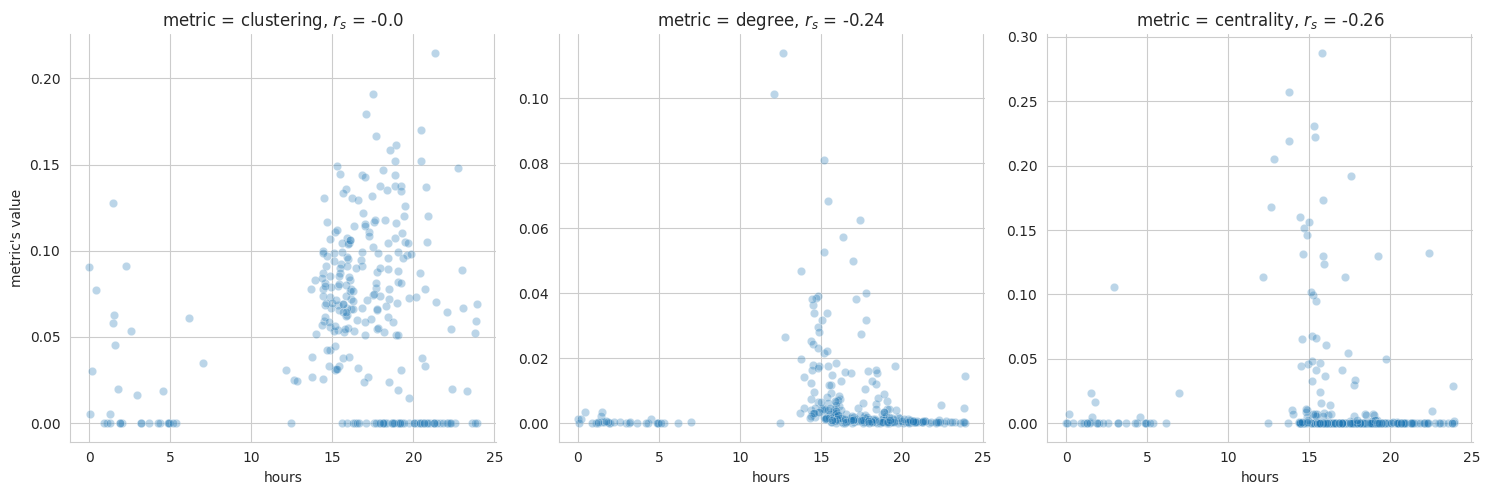

In [42]:
# Calculate Spearman correlation hours and metrics
scorr = ap_metrics.drop('dt', axis=1).corr('spearman').loc['hours']
# Create df for visualisation
ap_viz = ap_metrics.drop('dt', axis=1).reset_index().melt(id_vars=['index', 'hours'], var_name='metric')
# Visualisation
sns.set_style('whitegrid')
sp = sns.relplot(data=ap_viz, x='hours', y='value', col='metric', facet_kws={'sharey': False, 'sharex': True}, alpha=0.3)
# Modify labels
sp.set_ylabels("metric's value")
# Modify axes' titles to include correlation
axes = sp.fig.axes
for ax in axes:
    current_title = ax.get_title()
    metric_name = current_title.split(' ')[2]
    title = f'{current_title}, $r_{{s}}$ = {round(scorr[metric_name], 2)}'
    ax.set_title(title)
plt.show()

### Интерпретация результатов
В целом, мы видим слабую корреляцию либо ее отсутствие между медианным временем заражения и рассчитанными метриками:

1. Clustering $r_{s} = 0.25$
1. Centrality $r_{s} = -0.21$
1. Degree $r_{s} = -0.01$

#### Clustering coefficient
Коэффициент кластеризации (Clustering coefficient) это степень, с которой вершины графа стремятся скапливаться вместе. В данном случае, мы видим слабую положительную корреляцию ($r_{s} = 0.25$) в том, что аэропорты с более высокой степенью кластеризации будут инфицированы позже. Одним из возможных объяснений этому может быть то, что такие кластеры имеют больше внутренних рейсов, то есть, рейсов между аэропортами внутри кластера, чем внешних. Это замедляет попадание инфекции в кластер и, таким образом, усложняет заражение всего кластера.  

#### Shortest-path betweenness centrality
Степень посредничества (Shortest-path betweenness centrality) это мера центральности в графе, основанная на кратчайших путях. Мы видим слабую отрицательную корреляцию ($r_{s} = -0.21$) со временем заражения аэропорта. Это может объясняться тем, что аэропорты с высокой степенью центральности являются хабами, то есть, много рейсов проходят через них и таким образом, у инфекции есть много различных путей, чтобы попасть и заразить такой аэропорт.

#### Degree
Степенью (Degree) узла сети называют число его связей с другими узлами, для взвешенного графа это сумма весов граней с соседними узлами.
Близкая к нуля корреляция ($r_{s} = -0.01$) со временем заражения означает, что количество связей с соседними узлами не влияет на скорость распространения инфекции и определяется другими факторами.